In [149]:
%matplotlib inline
from scipy import linalg
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Image
from math import (log,ceil,floor)
from scipy.fft import fft, ifft
from scipy.linalg import dft, inv, expm, norm
from numpy.linalg import matrix_power
import networkx as nx
from qiskit import( ClassicalRegister,
        QuantumRegister,
        QuantumCircuit,
        execute,
        Aer,
        IBMQ,
        transpile)
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import( plot_histogram,
                        plot_state_city,
                        plot_gate_map, 
                        plot_circuit_layout)
from qiskit.circuit.library import QFT
style = {'figwidth':5,'fontsize':15,'subfontsize':12}
styleWide = {'figwidth':25,'fontsize':17,'subfontsize':14}

plt.rcParams['figure.figsize'] = 10,8
matplotlib.rcParams.update({'font.size' : 15})

import warnings
warnings.filterwarnings("ignore")

In [150]:
def c_increment(n):
    c_inc = QuantumCircuit(n)
    controls = [x for x in range(n-1)]
    for p in range(n-1):
        c_inc.mcx(controls,controls[-1] + 1)
        controls.pop()
    c_inc.x(0)
    c_inc = c_inc.to_gate()
    c_inc.name = '    INC    '
    c_inc = c_inc.control()
    return c_inc
    
def c_decrement(n):
    c_dec = QuantumCircuit(n)
    controls = [x for x in range(n-1)]
    c_dec.x(controls)
    for p in range(n-2):
        c_dec.mcx(controls,controls[-1] + 1)
        c_dec.x(controls[-1])
        controls.pop()   
    c_dec.cx(0,1)
    c_dec = c_dec.to_gate()
    c_dec.name = '    DEC    '
    c_dec = c_dec.control()
    return c_dec

def initialCond(qc,string,N):
    for x in range(N):
        if string[x] == '1':
            qc.x(x)
    return qc


def runCoinedWalk(n,steps,initString,invCoin=False):
    qw_qc = QuantumCircuit(n+1,n)
    u_inc = c_increment(n)
    u_dec = c_decrement(n)
    #--- Initial Condition
    qw_qc = initialCond(qw_qc,initString,n)
    if invCoin:
        qw_qc.x(-1)
    qw_qc.barrier()
    #--- Diffusion
    for t in range(steps):
        qw_qc.h(n)
        qw_qc.x(n)
        qw_qc.append(u_inc, [n]+list(range(0, n)))
        qw_qc.x(n)
        qw_qc.append(u_dec, [n]+list(range(0, n)))
        qw_qc.barrier()
    qw_qc.measure(range(n),range(n))
    return qw_qc

def runCoinedWalkSup(n,steps,initString):
    qw_qc = QuantumCircuit(n+1,n)
    u_inc = c_increment(n)
    u_dec = c_decrement(n)
    #--- Initial Condition
    qw_qc = initialCond(qw_qc,initString,n)
    qw_qc.h(n)
    qw_qc.s(n)
    qw_qc.barrier()
    #--- Diffusion
    for t in range(steps):
        qw_qc.h(n)
        qw_qc.x(n)
        qw_qc.append(u_inc, [n]+list(range(0, n)))
        qw_qc.x(n)
        qw_qc.append(u_dec, [n]+list(range(0, n)))
        qw_qc.barrier()
    qw_qc.measure(range(n),range(n))
    return qw_qc

In [156]:
def simul(qc,stateVec,shots):
    if stateVec:
        backend = Aer.get_backend('statevector_simulator')
        result = execute(qc,backend,shots=shots).result().get_statevector(qc,decimals=3)
    else:
        backend = Aer.get_backend('qasm_simulator')
        result = execute(qc
                         ,backend,shots=shots).result().get_counts()
    return result

def baseResultDict(n,decimal):
    "Retuns a dictionary composed of a range of N keys converted to binary."
    baseDict = {}
    if decimal:
        for decNumber in range(2**n):
            dec = decNumber 
            baseDict[dec] = 0
    else:
        for decNumber in range(2**n):
            decToBin = bin(decNumber)[2:].zfill(ceil(log(2**n,2)))
            baseDict[str(decToBin)] = 0  
    return baseDict

def normalizedResultDict(baseDict,qiskitDict):
    "Returns the result of merging qiskit produced dictionaries with dictionaries produced from multBinResultDict for graph formatting reasons."
    normalizedResultDict = {**baseDict,**qiskitDict}
    normalizedResultDict = {k:float(v) for k,v in normalizedResultDict.items() }
    return normalizedResultDict

def resultsSim(N,circ,shots,Decimal):
    "Returns the dictionary produced by QASM simulator with the MSB changed to convention, and values (previously frequencies) converted to probabilities."
    result = simul(circ,False,shots)
    baseDict = baseResultDict(N,Decimal)
    if Decimal:
        probResult = { int(k,2) : v/sum(result.values()) for k, v in result.items()}
    else:
        probResult = { k : v/sum(result.values()) for k, v in result.items()}
    correctedResult = normalizedResultDict(baseDict,probResult)
    return correctedResult


{3: 0.4842, 5: 0.5158}
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.4842, 4: 0.0, 5: 0.5158, 6: 0.0, 7: 0.0}


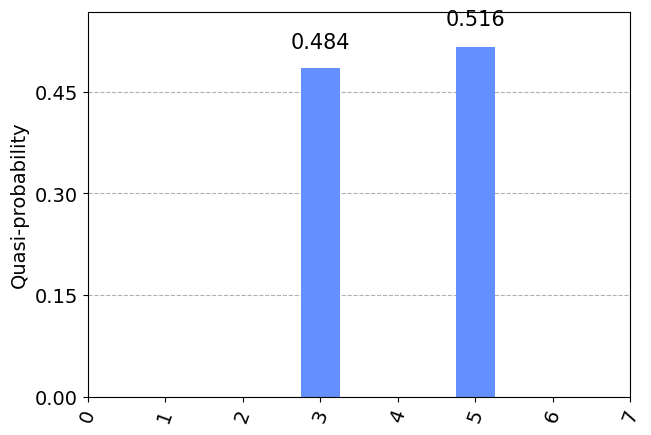

1.0


In [157]:
N = 3
steps = 1
shots = 5000
initString = '001'
walkCirc = runCoinedWalk(N,steps,initString)
results = resultsSim(N,walkCirc,shots,True)

display(plot_histogram(results))

a=0

for k,v in results.items():
    a += v
print(a)



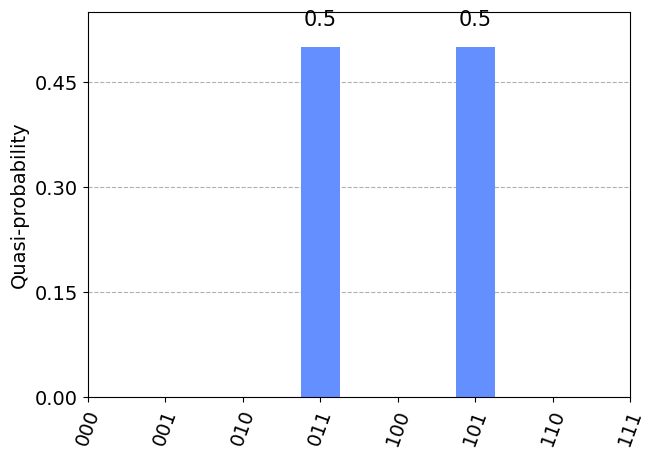

In [144]:
from qiskit.visualization import plot_histogram

# data = {'000': 0.5,'001': 0, '010': 0,'011': 0.5, '100': 0,'101': 0,'110':0,'111': 0}
# data = {'000': 0.0, '001': 0, '010': 0, '011': 0.5, '100': 0, '101': 0.5, '110': 0, '111': 0}
# data = {'000': 0.0, '001': 0.0, '010': 0.0, '011': 0.5, '100': 0.0, '101': 0.5, '110': 0.0, '111': 0.0}

# plot_histogram(data)